Get data

In [17]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from loguru import logger
import numpy as np

In [18]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
wa_df = pd.read_parquet(datafile)
wa_df.head()

,timestamp,message,living_in_city,tech_background,author,has_emoji,emoji_count,word_count,react_time_sec,react_time_min,react_time_hr,is_image,is_empty_message,is_removed_message,sentiment_polarity,sentiment_category
0,2022-09-16 07:31:00+00:00,Wachten op dit bericht,1,1,spattered-duck,False,0,4.0,NaN,NaN,NaN,0,1,0,0.0,Neutral
1,2022-09-16 07:41:00+00:00,Wachten op dit bericht,0,1,riotous-dingo,False,0,4.0,600.0,10.0,0.166667,0,1,0,0.0,Neutral
2,2022-09-16 08:21:00+00:00,Wachten op dit bericht,0,0,translucent-dog,False,0,4.0,2400.0,40.0,0.666667,0,1,0,0.0,Neutral
3,2022-09-16 08:23:00+00:00,Wachten op dit bericht,0,0,hypnotic-rabbit,False,0,4.0,120.0,2.0,0.033333,0,1,0,0.0,Neutral
4,2022-09-16 09:08:00+00:00,Wachten op dit bericht,0,1,crystalline-uakari,False,0,4.0,2700.0,45.0,0.750000,0,1,0,0.0,Neutral


Define bin_time

In [25]:
wa_df["time"] = wa_df["timestamp"].apply(pd.to_datetime, unit="s")

In [29]:
wa_df.head()

,timestamp,message,living_in_city,tech_background,author,has_emoji,emoji_count,word_count,react_time_sec,react_time_min,react_time_hr,is_image,is_empty_message,is_removed_message,sentiment_polarity,sentiment_category,time
0,2022-09-16 07:31:00+00:00,Wachten op dit bericht,1,1,spattered-duck,False,0,4.0,NaN,NaN,NaN,0,1,0,0.0,Neutral,2022-09-16 07:31:00+00:00
1,2022-09-16 07:41:00+00:00,Wachten op dit bericht,0,1,riotous-dingo,False,0,4.0,600.0,10.0,0.166667,0,1,0,0.0,Neutral,2022-09-16 07:41:00+00:00
2,2022-09-16 08:21:00+00:00,Wachten op dit bericht,0,0,translucent-dog,False,0,4.0,2400.0,40.0,0.666667,0,1,0,0.0,Neutral,2022-09-16 08:21:00+00:00
3,2022-09-16 08:23:00+00:00,Wachten op dit bericht,0,0,hypnotic-rabbit,False,0,4.0,120.0,2.0,0.033333,0,1,0,0.0,Neutral,2022-09-16 08:23:00+00:00
4,2022-09-16 09:08:00+00:00,Wachten op dit bericht,0,1,crystalline-uakari,False,0,4.0,2700.0,45.0,0.750000,0,1,0,0.0,Neutral,2022-09-16 09:08:00+00:00


In [28]:
import pandas as pd

# Define the bins (these are timezone-naive)
bins = [
    pd.to_datetime("2023-01-01"),
    pd.to_datetime("2023-07-01"),
    pd.to_datetime("2024-01-01"),
    pd.to_datetime("2025-01-01")
]

# Convert the 'time' column to be timezone-naive before cutting
wa_df["bintime"] = pd.cut(
    wa_df["time"].dt.tz_localize(None),
    bins,
    labels=[0, 1, 2, 3]
)

ValueError: Bin labels must be one fewer than the number of bin edges

Define authors

In [19]:
authors = list(np.unique(wa_df.author))

In [20]:
print(authors)

['brisk-sheep', 'crystalline-uakari', 'effervescent-penguin', 'eye-catching-wolf', 'hypnotic-rabbit', 'nutty-chough', 'riotous-dingo', 'spattered-duck', 'translucent-dog']


Remove URL with function

In [21]:
import re

def remove_url(text):
    return re.sub(r"^https?:\/\/.*[\r\n]*", "", text)

Take subset of author, join texts. Concatenate

In [22]:
n = 500
min_parts = 2

corpus = {}
for author in authors:
    subset = wa_df[wa_df.author == author].reset_index()

    # Filter out None values from the 'message' column before joining
    filtered_messages = [str(msg) for msg in subset.message if msg is not None]

    # Check if there are any non-None messages to join
    if filtered_messages:
        longseq = " ".join(filtered_messages)
        # chunk everything into n-sized parts
        parts = [longseq[i : i + n] for i in range(0, len(longseq), n)]
        # clean urls
        parts = [remove_url(chunk) for chunk in parts]
        # remove double spaces
        parts = [re.sub(" +", " ", chunk) for chunk in parts]
        # keep only parts with more than min_parts
        if len(parts) > min_parts:
            corpus[author] = parts

corpus.keys()

dict_keys(['brisk-sheep', 'crystalline-uakari', 'effervescent-penguin', 'eye-catching-wolf', 'hypnotic-rabbit', 'nutty-chough', 'riotous-dingo', 'spattered-duck', 'translucent-dog'])

In [23]:
print(corpus)

{'brisk-sheep': ['Wachten op dit bericht Bas, van harte gefeliciteerd met je verjaardag! Als ik terug ben gaan we er een paar drinken!!🍷🎂 Ik ben dan nog in Italië man😬 Volgende week ben ik weer terug! Ik helaas niet Ben dan in Normandië Ik ben met mijn vader dat weekend in Normandië We gaan naar de stranden waar de geallieerden landen op 6 juni 1943 Pap wilden ze graag zien en ik ga mee Voor obelix nog wel😂 Ik vond juist een rol als Panoramix voor mij goed weggelegd😂 Zelfs mijn had mij geappt gisteren dat het zo ', 'verschrikkelijk slecht ging😬 had oorspronkelijk de wedstrijd willen kijken in een bar in Rome maar dat zou ik helaas niet redden met mijn vlucht Net weer aangekomen in NL heren! Nou Thomas! Van harte gefeliciteerd!! Welkom bij de club😂😂 Volgend jaar krijg je nog een spandoek, want deze was net te braaf🙈 Is de verkoop nu al?😂 Zou iemand ook voor mij kunnen halen? Voor zaterdag Wie zijn er op dit moment in Losser dan, en zouden kaartjes kunnen halen😬😇 Jeetje wat ouderwets😂 je

Import clustering

In [24]:
import sys

sys.path.insert(0, "..")

sourcemean = np.round(corpus.groupby("group").source.mean()).values.reshape(-1, 1)

from wa_analyzer.model import TextClustering

clustering = TextClustering()
labels = sourcemean.flatten().astype(str)
clustering(text=df["text"], k=100, labels=labels, batch=True, method="PCA")

AttributeError: 'dict' object has no attribute 'groupby'

In [ ]:
import matplotlib.pyplot as plt

text = [part for text in corpus.values() for part in text]
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
# we set batch to false, because we already batched the data
clustering(text=text, k=100, labels=wa_labels, batch=False, method="tSNE")
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks([])
plt.yticks([])
plt.title("Distinct authors in the WhatsApp dataset")

Experiment

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def synthetic_data(seed: int = 42, m: int = 60) -> np.array:
    np.random.seed(seed)
    # two weigths
    w1, w2 = 0.1, 0.3
    # some noise
    noise = 0.1

    # m random angles
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    X = np.empty((m, 3))  # noqa: N806
    X[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
    X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)
    return X


X = synthetic_data(seed=4, m=100)

In [2]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
U.shape, s.shape, Vt.shape

((100, 100), (3,), (3, 3))

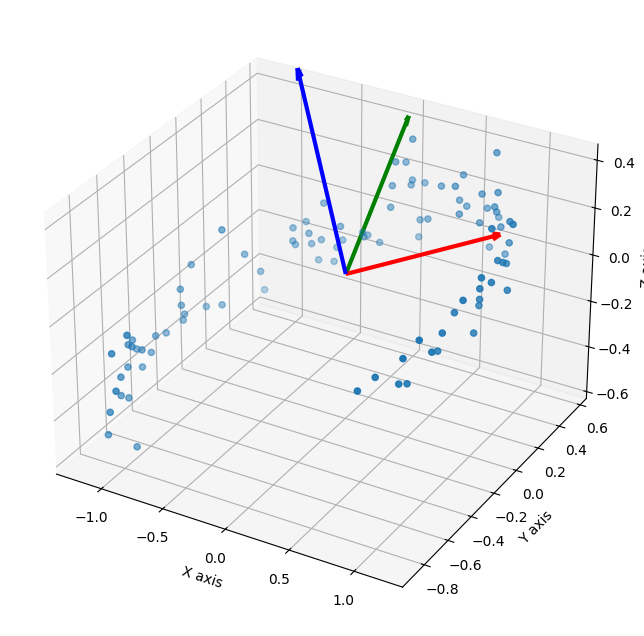

In [3]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot of the original data
ax.scatter(X_centered[:, 0], X_centered[:, 1], X_centered[:, 2])

# The principal components are the rows of Vt. We scale them by the square root of the eigenvalues (s**2).
for i in range(Vt.shape[0]):
    # Start the line in the middle of the data
    start_point = np.zeros(3)
    # The end of the line is the direction of the principal component
    end_point = Vt[i, :]
    # Plot the principal components as lines
    ax.quiver(
        start_point[0],
        start_point[1],
        start_point[2],
        end_point[0],
        end_point[1],
        end_point[2],
        color=["r", "g", "b"][i],
        arrow_length_ratio=0.05,
        linewidths=3,
    )

# Set labels for axes
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")

# Show the plot
plt.show()